In [1]:
import pandas as pd
import numpy as np


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from src.utils import preprocess, split_dataframe

import os

from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = 'data'
csv_fn = os.path.join(data_path, 'data_science_dataset_test_task.csv')

### Data preprocessing

In [3]:
cols_to_drop = ['Unnamed: 0',
                  'user_id',
                  'current_dt',
                  'scheduled_dt',
                  'root_order_id',
                  'old_model_probability',]

categorical_cols = ['os_family',
                    'lt_user',
                    'country_code', 
                    'phone', 
                    'hours_after_reg_buy',
                    'period',
                    'discount',
                    'currency_id',
                    'cpa',
                    'psp',
                    'last_response_code',
                    'bank',
                    'card_type', 
                    'card_country_code']

df = pd.read_csv(csv_fn)
df = df.drop(cols_to_drop, axis=1)
train, val = split_dataframe(df, on_time=False)

train = preprocess(train, categorical_cols, subset='train')
val = preprocess(val, categorical_cols, subset='eval')

x_train, y_train = train.drop(['is_success'], axis=1), train['is_success']
x_val, y_val = val.drop(['is_success'], axis=1), val['is_success']

In [6]:
x_train

,index,gender,age,os_family,lt_user,hours_after_reg_buy,country_code,phone,cpa,retry_number,...,last_response_code,bank,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross
0,198441,0,43,0.198403,0.260657,0.204343,0.250063,0.179124,0.212243,0,...,0.329921,0.112357,0,0.201512,0.245397,1,0,0,0.54,0.00
1,328438,0,29,0.234376,0.133627,0.215107,0.194819,0.233612,0.242636,0,...,0.102799,0.196884,0,0.201512,0.195213,1,1,1,0.38,0.00
2,473138,1,63,0.198403,0.249178,0.212328,0.194819,0.171660,0.076923,0,...,0.102799,0.223229,0,0.201512,0.195213,1,1,1,0.47,0.00
3,82583,0,47,0.198403,0.135090,0.208197,0.194819,0.194390,0.159325,1,...,0.102799,0.196884,0,0.201512,0.195213,1,2,2,0.47,0.00
4,415273,0,29,0.198403,0.135090,0.208197,0.112498,0.216778,0.000000,1,...,0.086318,0.073403,0,0.201512,0.109288,1,1,0,1.17,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411563,259178,0,44,0.198403,0.133627,0.161093,0.236962,0.203016,0.194143,0,...,0.102799,0.281879,0,0.201512,0.200434,3,1,1,0.45,6.42
411564,365838,0,27,0.234376,0.260657,0.204343,0.194819,0.233612,0.194143,0,...,0.342141,0.196884,0,0.201512,0.195213,1,1,0,0.38,0.00
411565,131932,0,31,0.198403,0.260657,0.186208,0.250063,0.216778,0.194143,0,...,0.102799,0.226350,0,0.237747,0.245397,1,1,1,0.54,0.00
411566,146867,1,38,0.198403,0.249178,0.204343,0.194819,0.232816,0.377358,0,...,0.329921,0.196884,0,0.201512,0.195213,1,0,0,0.44,0.00


### Model build

In [4]:
model = XGBClassifier(eval_metric='logloss',
                      use_label_encoder=False)

model.fit(x_train, y_train)
predictions = model.predict(x_val)

f1 = f1_score(predictions, y_val)
roc_auc = roc_auc_score(predictions, y_val)

print('----------------------------')
print('Model f1: ', f1)
print('Model roc_auc: ', roc_auc)

----------------------------
Model f1:  0.330988297368599
Model roc_auc:  0.7055758084275837


Model f1 score  0.5050642701926265  threshold  0.24


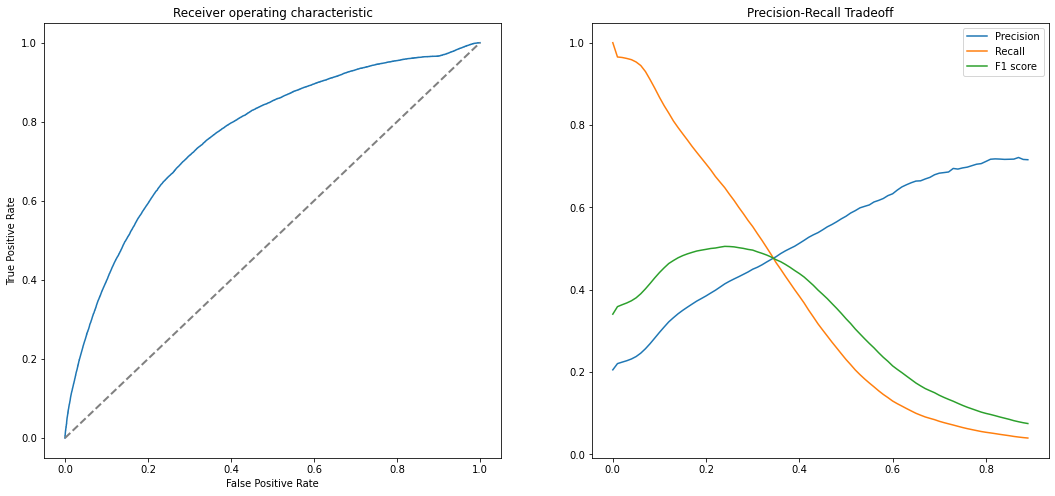

In [5]:
predictions_prob = model.predict_proba(x_val)

fpr, tpr, _ = roc_curve(y_val, predictions_prob[:,1])

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

lw = 2
ax[0].plot(fpr, tpr)
ax[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
ax[0].set_title('Receiver operating characteristic')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

precisions = []
recalls = []
f1s = []

x = np.arange(0, 0.9, 0.01)
for threshold in x:
    model_predictions = np.array(predictions_prob > threshold, dtype='int8')
    precision = precision_score(y_val, model_predictions[:,1])
    recall = recall_score(y_val, model_predictions[:,1])
    f1 = f1_score(y_val, model_predictions[:, 1])
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
print('Model f1 score ', np.max(f1s), ' threshold ', x[np.argmax(f1s)])

ax[1].set_title('Precision-Recall Tradeoff')
ax[1].plot(x, precisions, label='Precision')
ax[1].plot(x, recalls, label='Recall')
ax[1].plot(x, f1s, label='F1 score')
ax[1].legend()
plt.show()

### Hyperparameter tuning

In [6]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0,
        'objective': 'binary',
    }

In [7]:
def objective(space):
    clf = XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), ( x_val, y_val)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_val)
    f1 = f1_score(y_val, pred>0.5)
    return {'loss': -f1, 'status': STATUS_OK }

In [8]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|████████████████████████████████████████████| 100/100 [19:22<00:00, 11.63s/trial, best loss: -0.23407982937233396]


In [9]:
best_hyperparams

{'colsample_bytree': 0.5944565447891785,
 'gamma': 4.565509251341255,
 'max_depth': 17.0,
 'min_child_weight': 3.0,
 'reg_alpha': 41.0,
 'reg_lambda': 0.7774015314387444}

In [13]:
model = XGBClassifier(eval_metric='logloss',
                     use_label_encoder=False,
                     colsample_bytree=0.5944565447891785,
                     gamma=4.565509251341255,
                     max_depth=17,
                     min_child_weight=3,
                     reg_alpha=41,
                     reg_lambda=0.7774015314387444)

model.fit(x_train, y_train)
predictions = model.predict(x_val)

f1 = f1_score(predictions, y_val)
roc_auc = roc_auc_score(predictions, y_val)

print('----------------------------')
print('Model f1: ', f1)
print('Model roc_auc: ', roc_auc)

----------------------------
Model f1:  0.3334223706176962
Model roc_auc:  0.6987069439522093


Model f1 score  0.4998761078814447  threshold  0.25


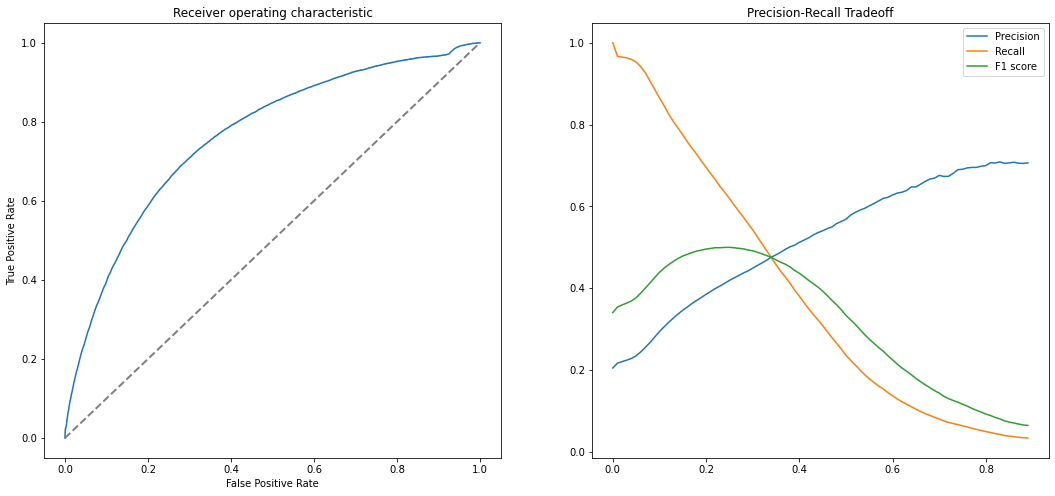

In [14]:
predictions_prob = model.predict_proba(x_val)

fpr, tpr, _ = roc_curve(y_val, predictions_prob[:,1])

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

lw = 2
ax[0].plot(fpr, tpr)
ax[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
ax[0].set_title('Receiver operating characteristic')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

precisions = []
recalls = []
f1s = []

x = np.arange(0, 0.9, 0.01)
for threshold in x:
    model_predictions = np.array(predictions_prob > threshold, dtype='int8')
    precision = precision_score(y_val, model_predictions[:,1])
    recall = recall_score(y_val, model_predictions[:,1])
    f1 = f1_score(y_val, model_predictions[:, 1])
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
print('Model f1 score ', np.max(f1s), ' threshold ', x[np.argmax(f1s)])

ax[1].set_title('Precision-Recall Tradeoff')
ax[1].plot(x, precisions, label='Precision')
ax[1].plot(x, recalls, label='Recall')
ax[1].plot(x, f1s, label='F1 score')
ax[1].legend()
plt.show()

In [15]:
import pickle
pickle.dump(model, open('model.pkl', "wb"))